In [68]:
%load_ext autoreload
%autoreload 2

from itertools import product
import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/')
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D
from PixelGen.metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pathlib import Path


import anndata as ad
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import train_model, get_model_latents
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA
from pixelator.common.statistics import clr_transformation, dsb_normalize


from pixelator.pna.plot import molecule_rank_plot
# from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
# from pixelator.statistics import c
# lr_transformation
# from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from PixelGen.pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from PixelGen.common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from PixelGen.metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D

import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl



# from cytovi import CytoVI

print(torch.cuda.is_available())
from sklearn.decomposition import PCA

from anndata import AnnData
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)

sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

from utils import plot_latent, plot_gene_heatmap, plot_model_latents,get_dense,calculate_metrics,plot_composite_ppc
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"
MODEL_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/models/'
ANNOTATED_ADATA_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/adata_annotated.h5ad'
ADATA_FOR_MODEL_PATH='/home/projects/nyosef/zvise/PxlgnProject/Data/final_adatas/adata_for_model.h5ad'
ADATA_SCALED_FOR_MODEL_PATH='/home/projects/nyosef/zvise/PxlgnProject/Data/final_adatas/adata_asinh_scaled_for_model.h5ad'

Seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
Last run with scvi-tools version: 1.3.3


In [ ]:
adata=sc.read_h5ad(ADATA_FOR_MODEL_PATH)

hotspot_results_dict= pd.read_pickle("/home/projects/nyosef/zvise/PixelGen/PixelGen/cache/HOTSPOT/hotspot_cache.pkl")
results=pd.DataFrame.from_dict(hotspot_results_dict, orient="index").fillna(0)

common = adata.obs_names.intersection(results.index)
adata = adata[common].copy()
adata.obsm["HOTSPOT"] = results.loc[adata.obs_names]

In [ ]:
spatial_layer=''

df = pd.DataFrame(adata.obsm[spatial_layer])  # convert obsm → DataFrame
var   = df.var()
zeros = (df == 0).mean()
score = var * (1 - zeros)

top500 = score.sort_values(ascending=False).head(500).index
adata.obsm[f"{spatial_layer}_top500_var"] = df[top500]

In [54]:
adata

AnnData object with n_obs × n_vars = 2253 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear'
    uns: 'neighbors', 'umap', 'leiden', 'condition_colors', 'run_colors', 'leiden_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'clr', 'log1p', 'spatial_asinh', 'spatial_quantile', 'spatial_raw', 'spatial_tanh4', 'HOTSPOT', 'spatial_arcsinh_top500_var', 'HOTSPOT_top500_var', 'X_umap'
    layers: 'arcsinh', 'clr', 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

# RUN MODELS

In [69]:
models_dict={}

model_cls = MultiModalSCVI
abundance_layer = 'arcsinh'
spatial_layer='HOTSPOT_top500_var'
max_epochs=10000


In [70]:
sp = adata.obsm[spatial_layer]
ab = adata.layers[abundance_layer]

X = np.concatenate([sp, ab], axis=1)

adata.obsm["pca"] = PCA(n_components=50).fit_transform(X)

INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: -224.105. Signaling Trainer to stop.


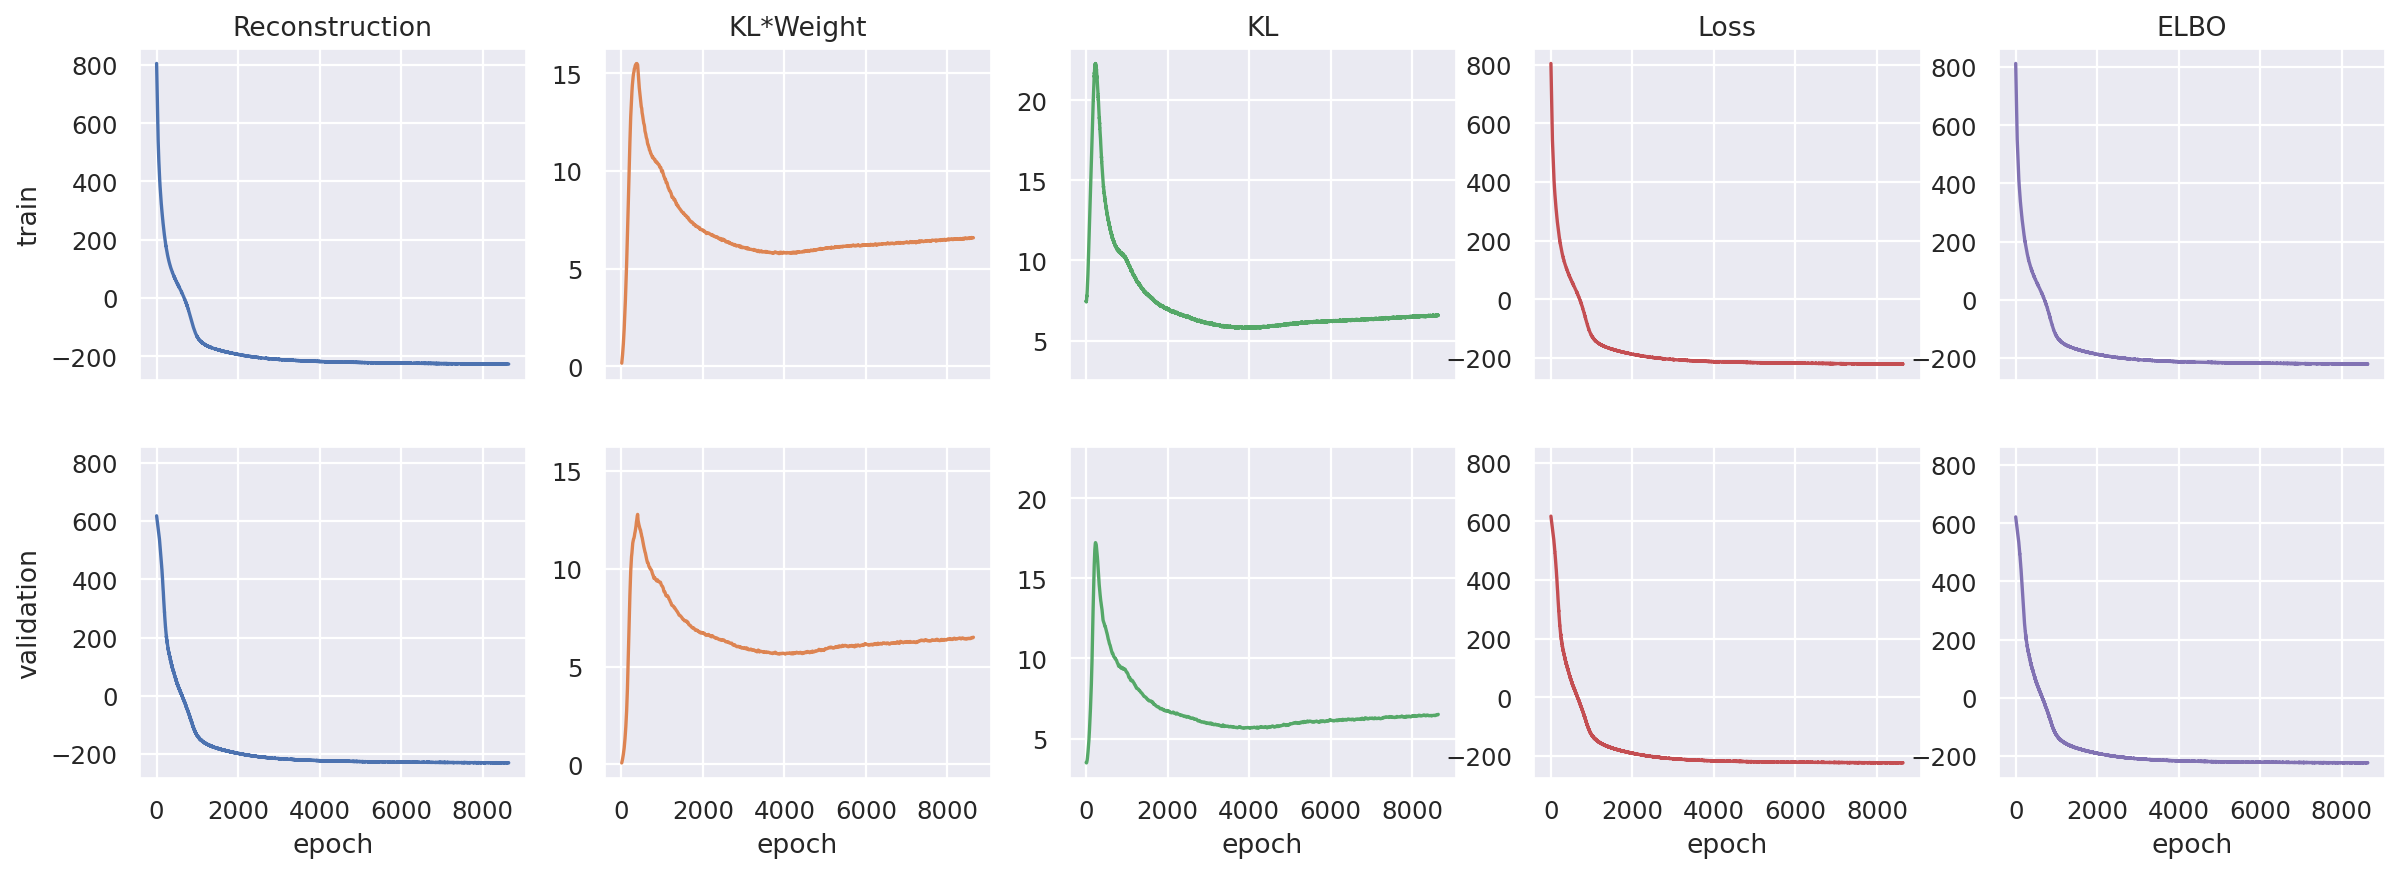

In [71]:
model_name='joint_encoders_POE_HOTSPOT'

setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='run', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            experts_method='POE',
                            loss_weights='auto',
                            joint_kl=False, unimodal_kl=True,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)
model.save(f'{MODEL_PATH}{model_name}',overwrite=True)

models_dict[model_name]=model

INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10000` reached.


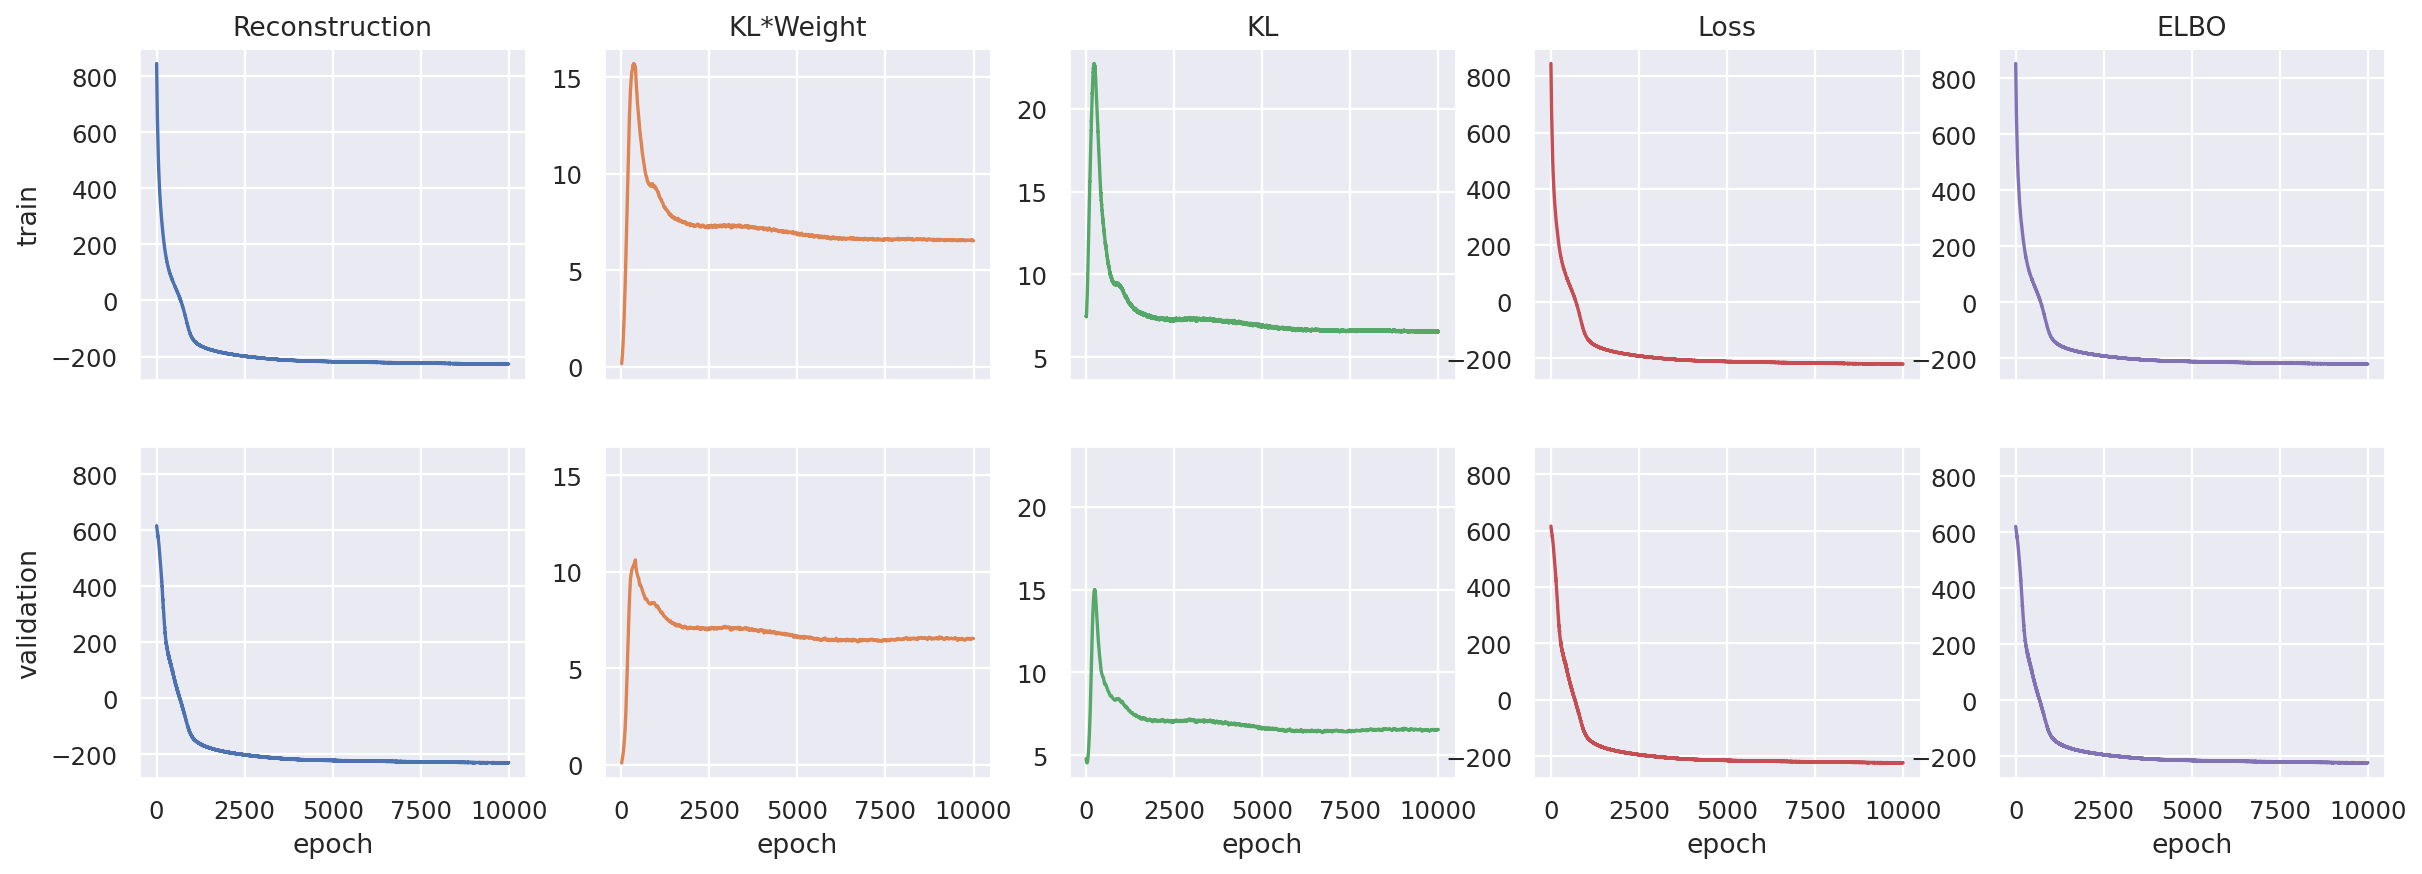

In [72]:
model_name='joint_encoders_MOE_HOTSPOT'

setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='run', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            experts_method='MOE',
                            loss_weights='auto',
                            joint_kl=False, unimodal_kl=True,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)
model.save(f'{MODEL_PATH}{model_name}',overwrite=True)

models_dict[model_name]=model



INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: -223.181. Signaling Trainer to stop.


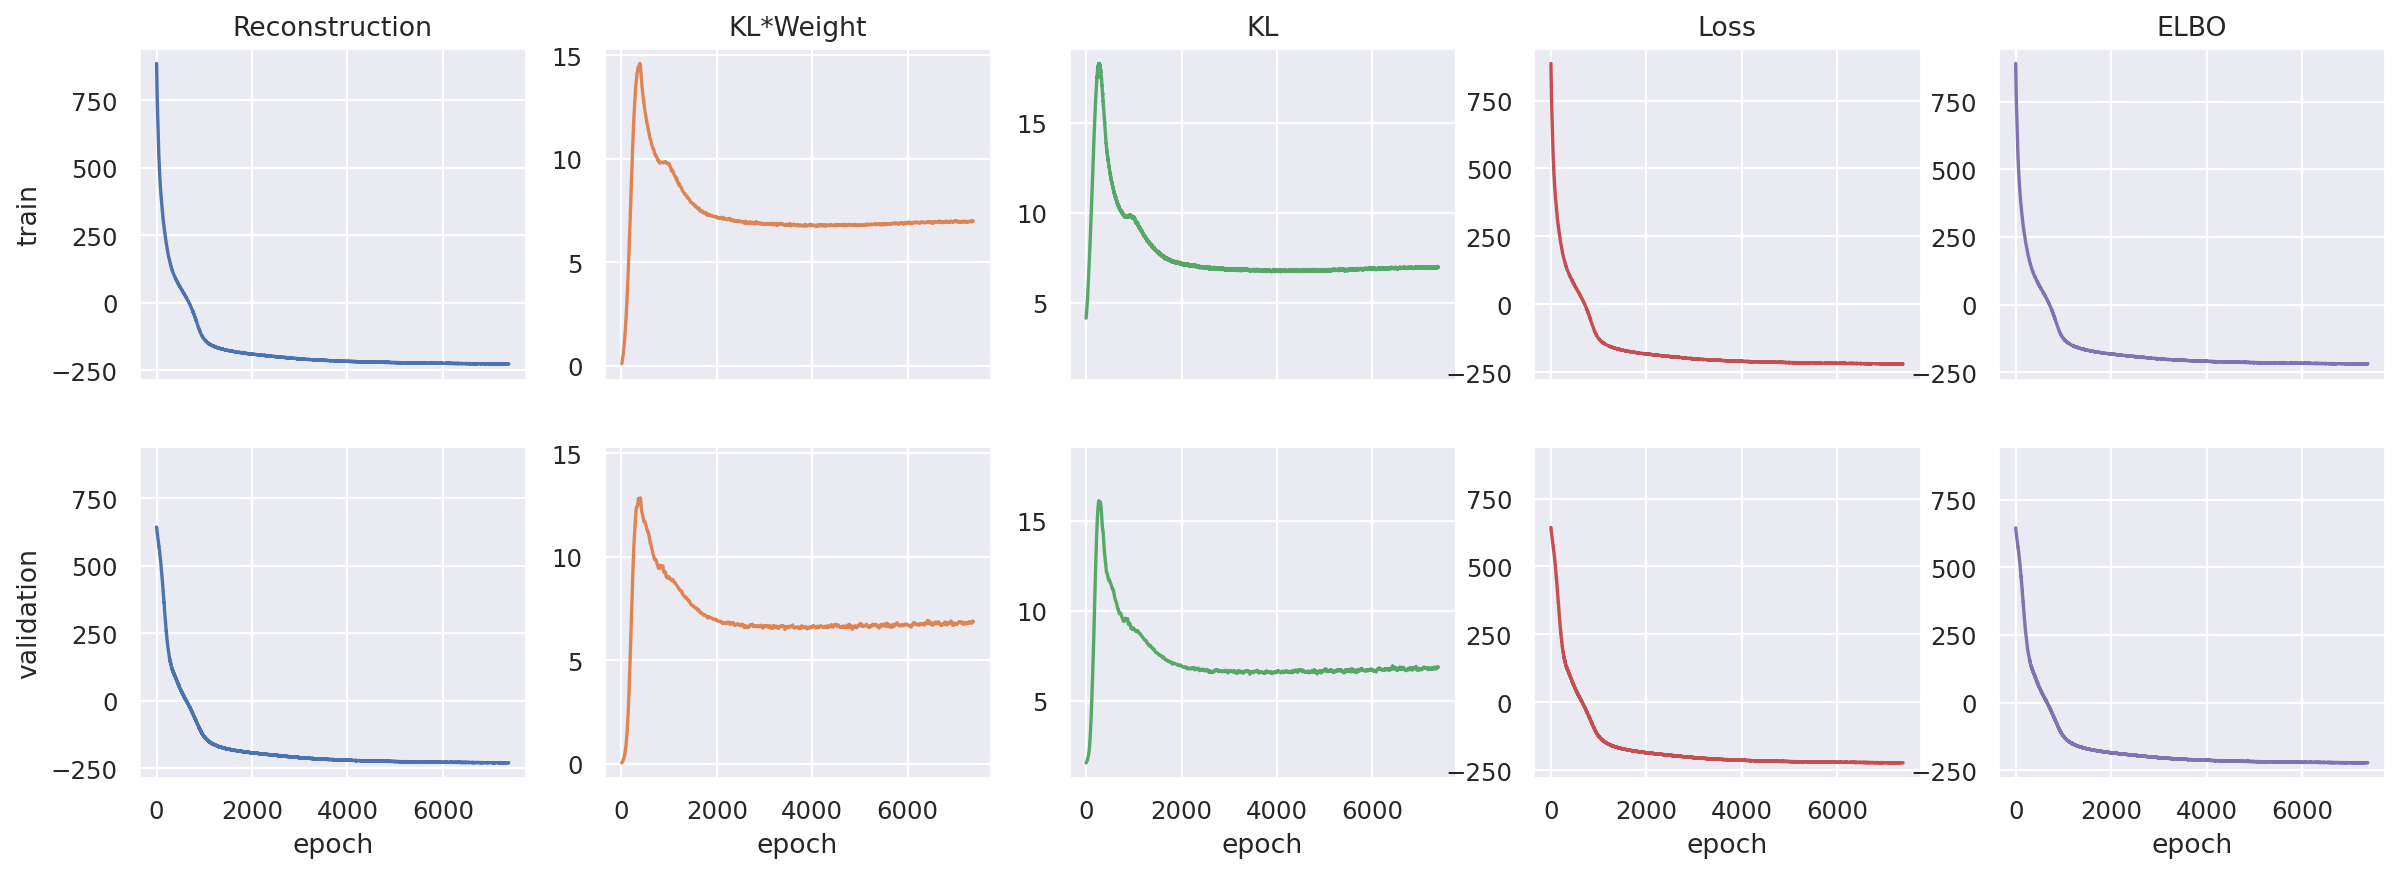

In [73]:
model_name='single_encoders_HOTSPOT'

setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='run', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            experts_method='MOE',
                            loss_weights='auto',
                            agg_method=AggMethod.SHARED_ENCODER,
                            joint_kl=True, unimodal_kl=False,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)
model.save(f'{MODEL_PATH}{model_name}',overwrite=True)

models_dict[model_name]=model


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: 109.150. Signaling Trainer to stop.


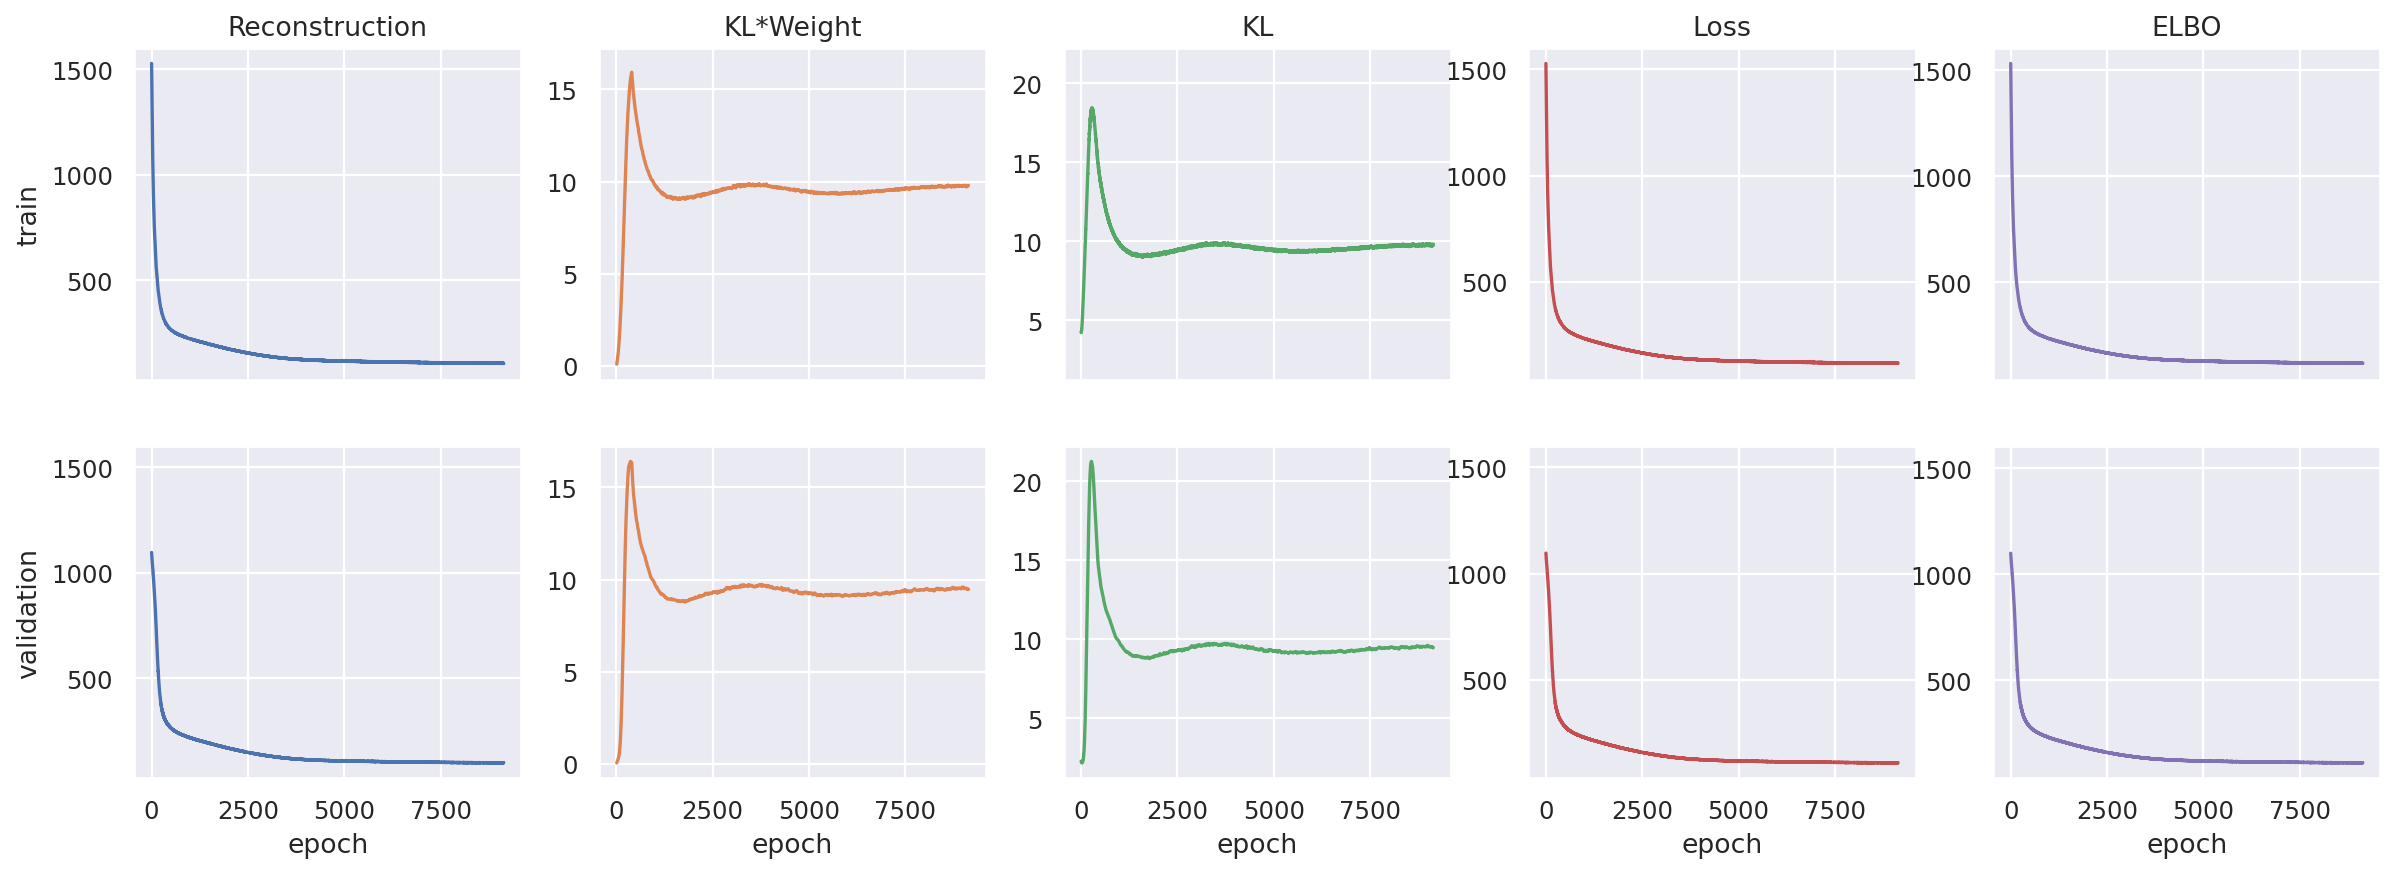

In [74]:
model_name='abundance_only'


setup_kwargs = dict(layer=abundance_layer, n_modalities=1, batch_key='run', spatial_mask_key=None,  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, ], 
                            loss_weights='auto',
                            external_kl_weight=1,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)
model.save(f'{MODEL_PATH}{model_name}',overwrite=True)

models_dict[model_name]=model


# METRICS

In [75]:
metrics=MultiModalVIMetrics(
    adata,
    models_dict,
    pca_key='pca',
    batch_key='run',
    biological_key='condition',
)

metrics.run()

Modalities indentified: ['arcsinh', 'HOTSPOT_top500_var']
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using

/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  20%|██        | 1/5 [00:07<00:31,  7.84s/it]/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future

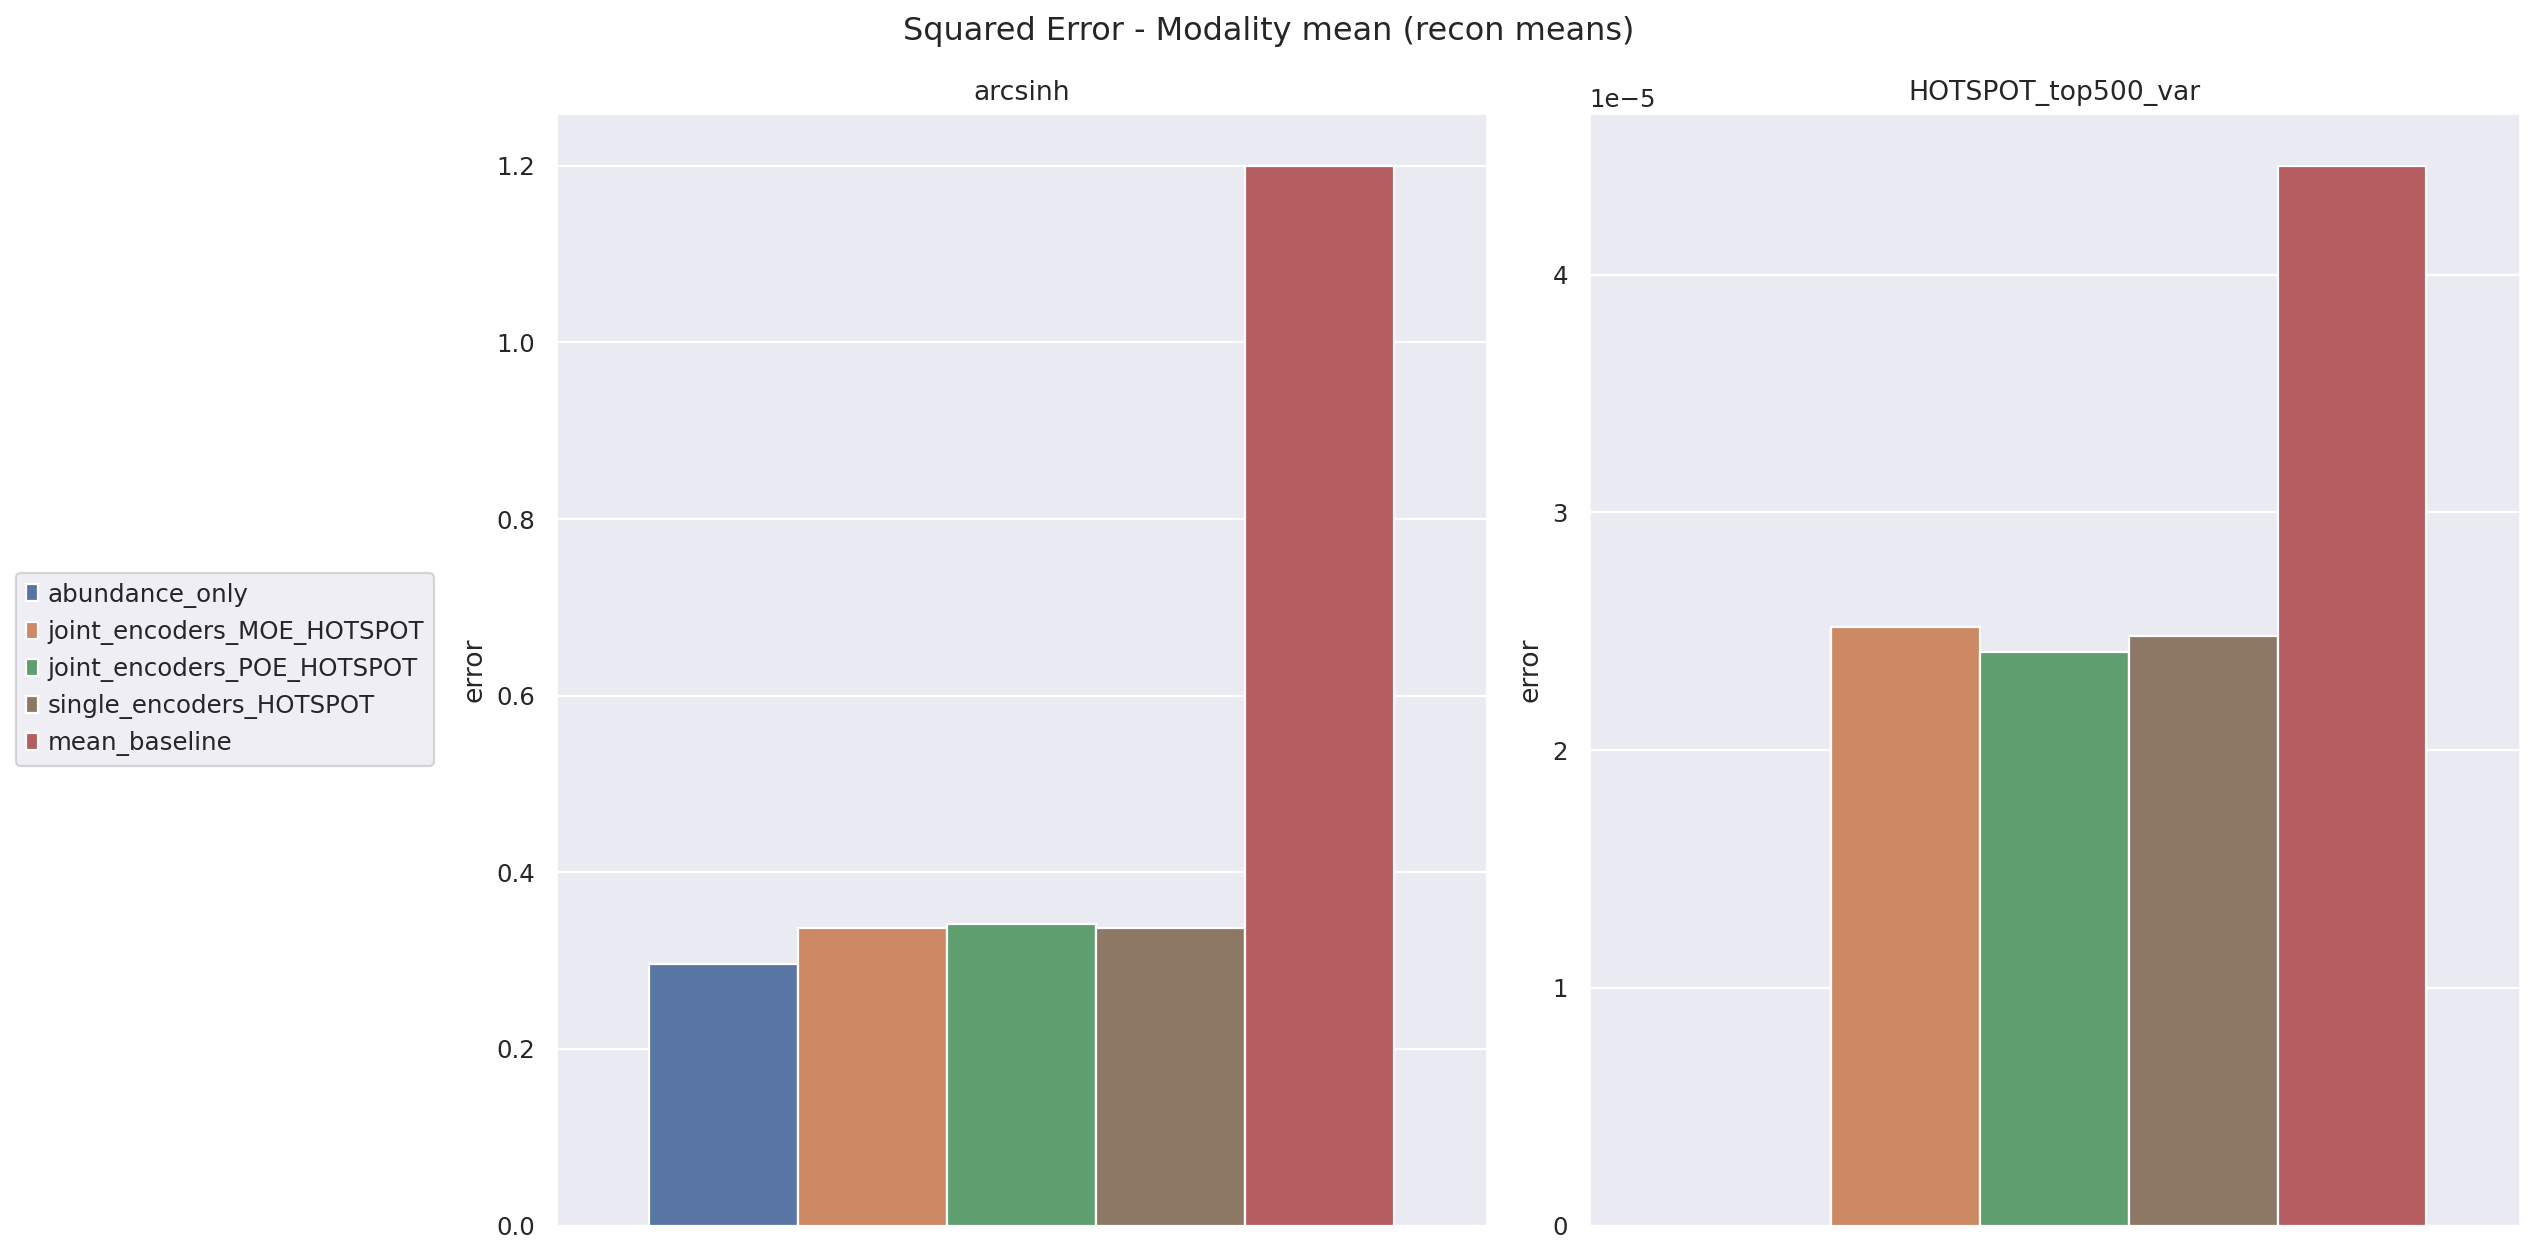

In [76]:
_ = metrics.mean_modality_errors_barplot(reconstruction_mean=True)

/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting a

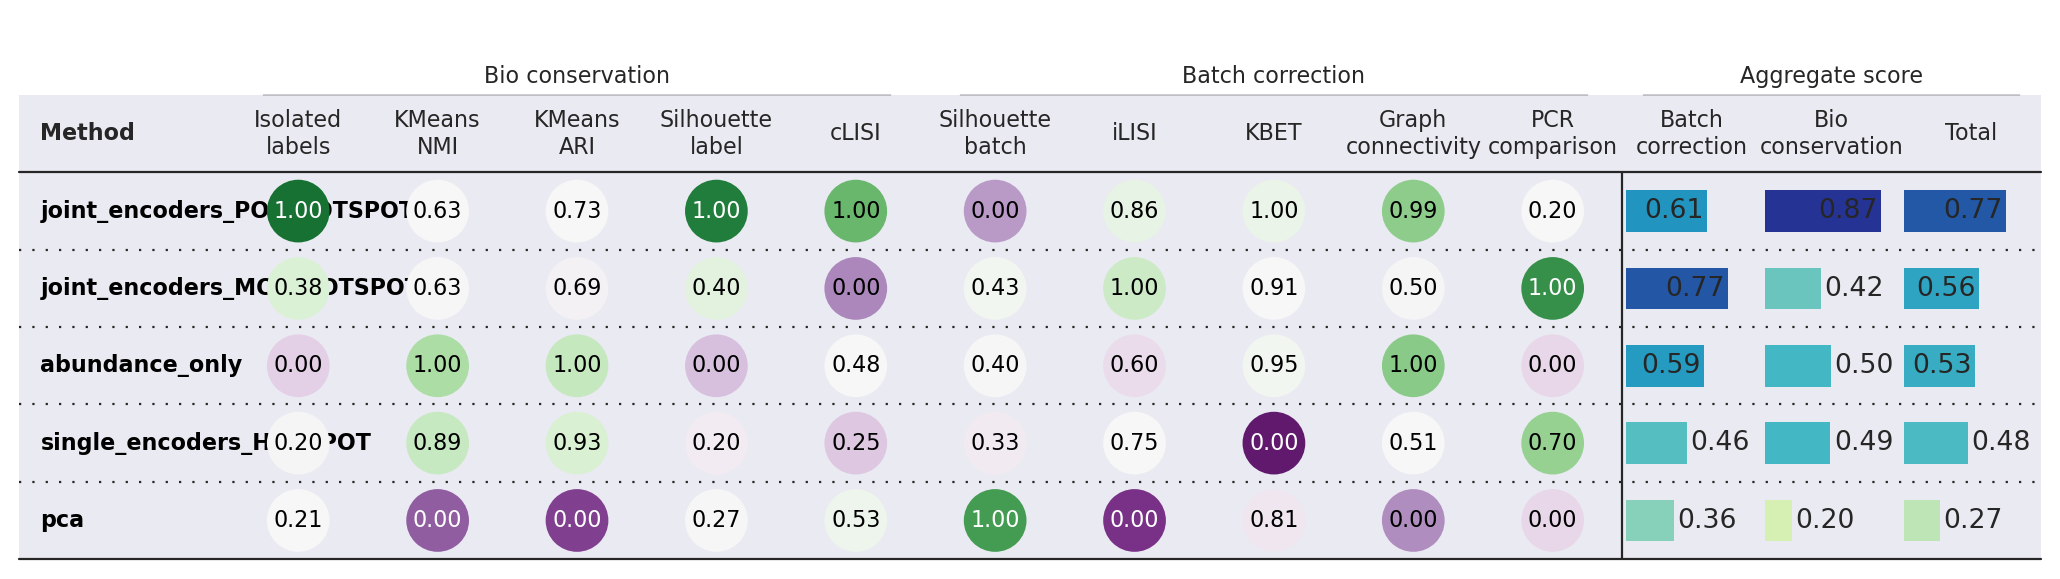

In [77]:
metrics.plot_scib_metrics()

In [ ]:
model=models_dict['abundance_only']

imputed = model.get_normalized_expression(
    adata=adata,
    return_mean_expression=True,
    return_l2_error=True,
    return_px_distrs=False,
    return_numpy=True
)

Calculating metrics for all models...
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       


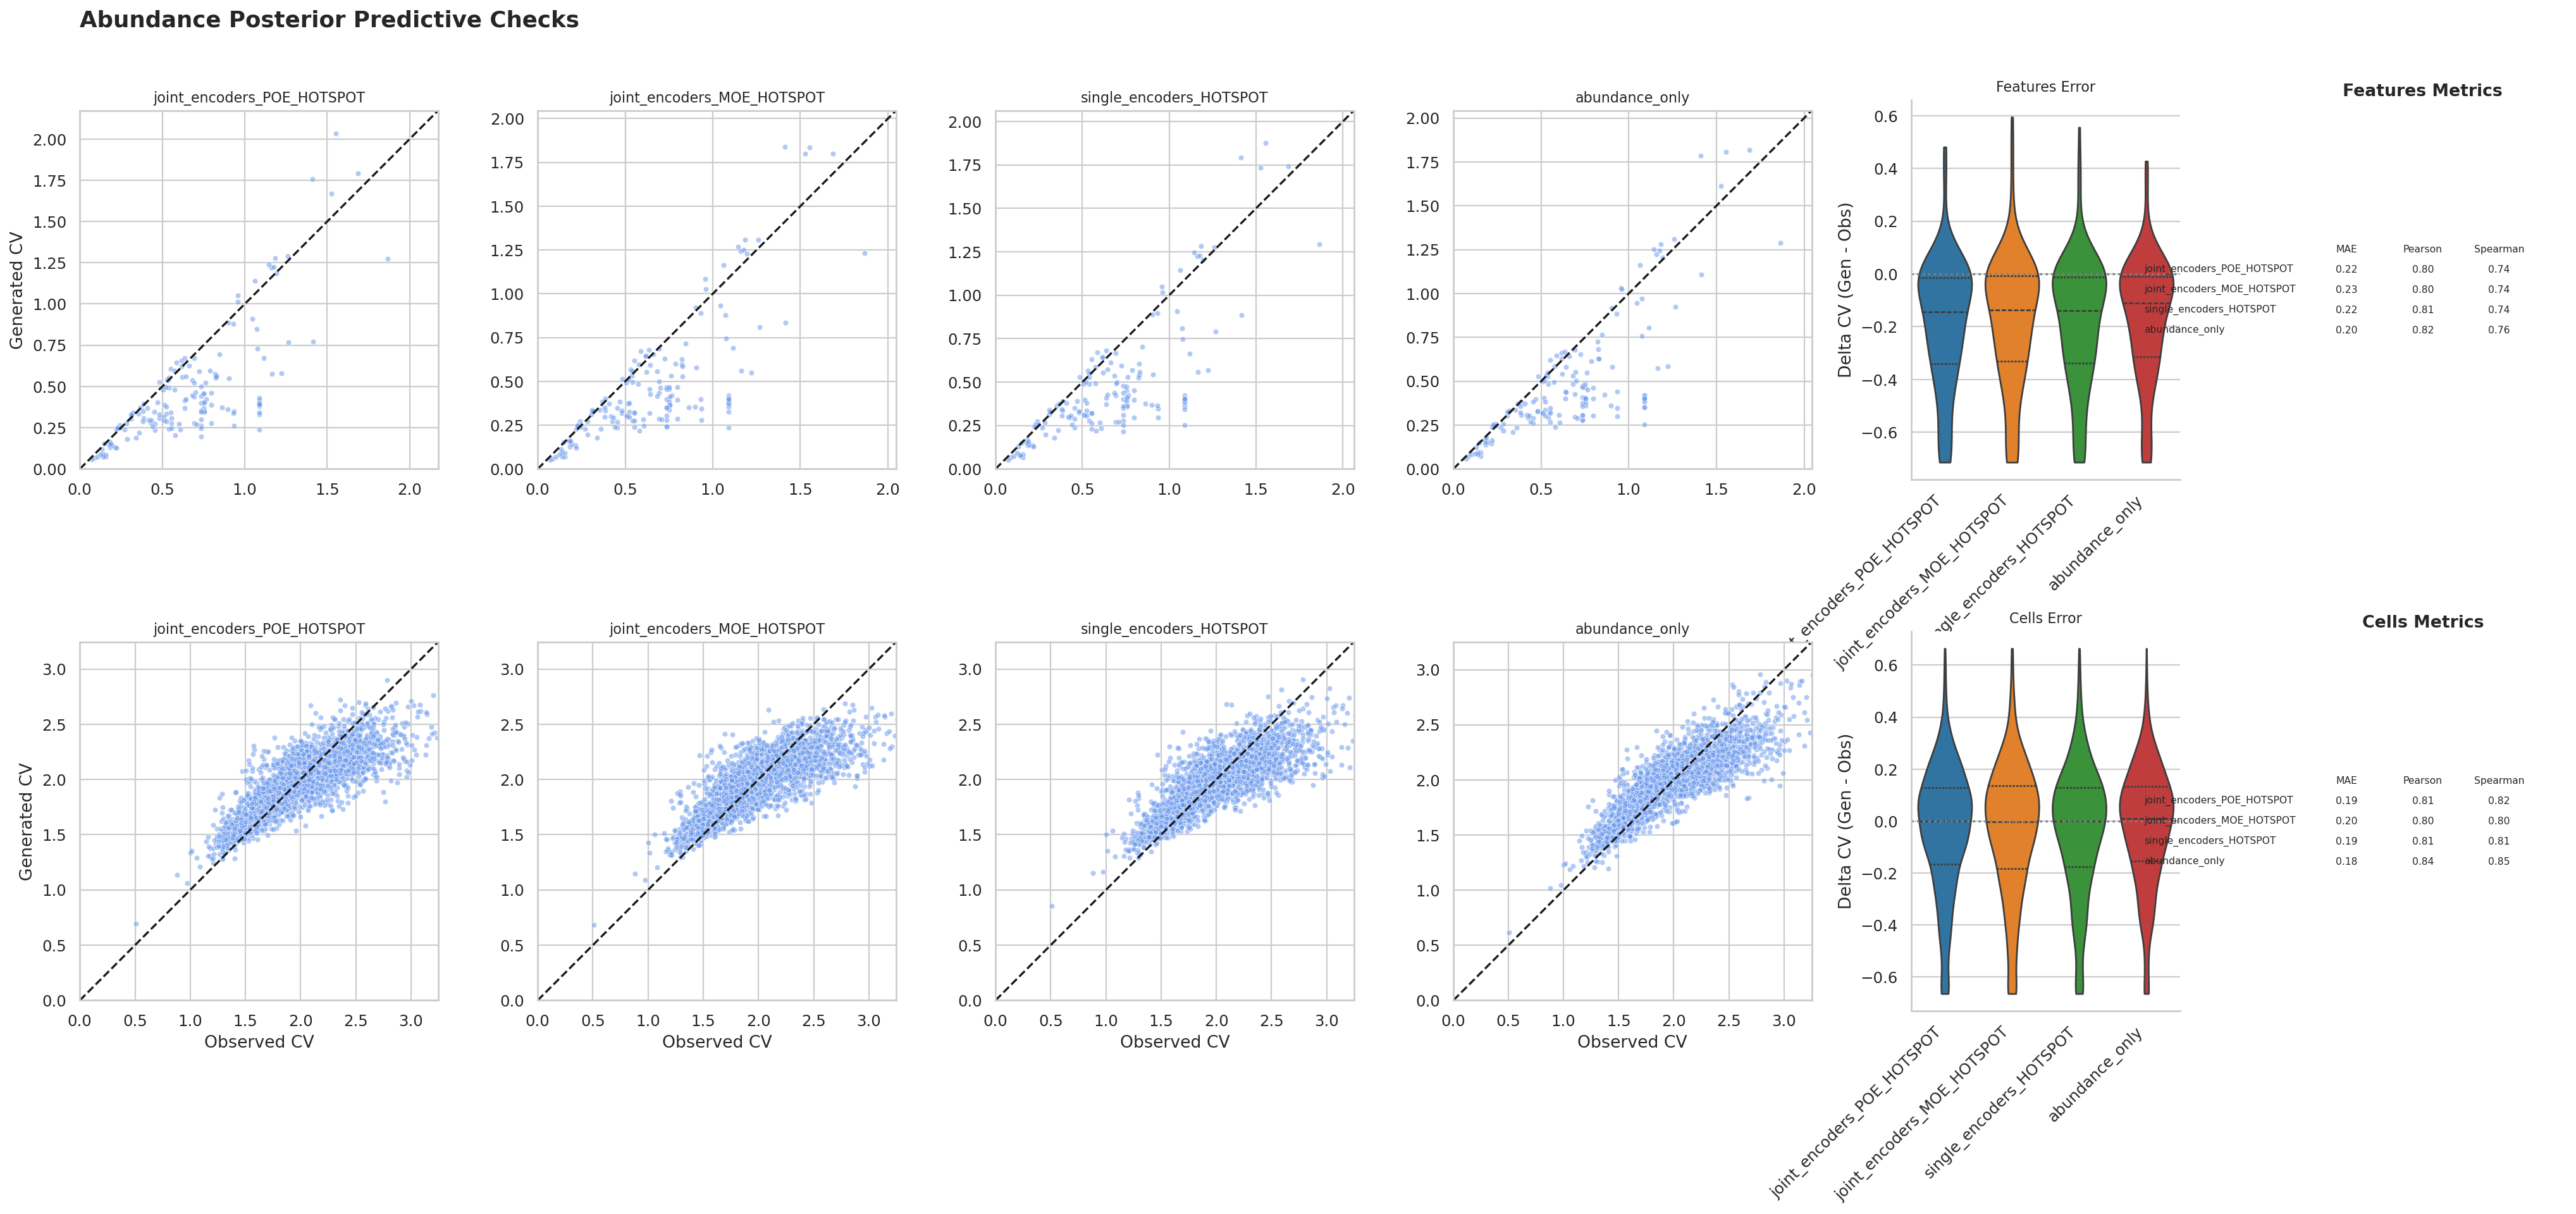

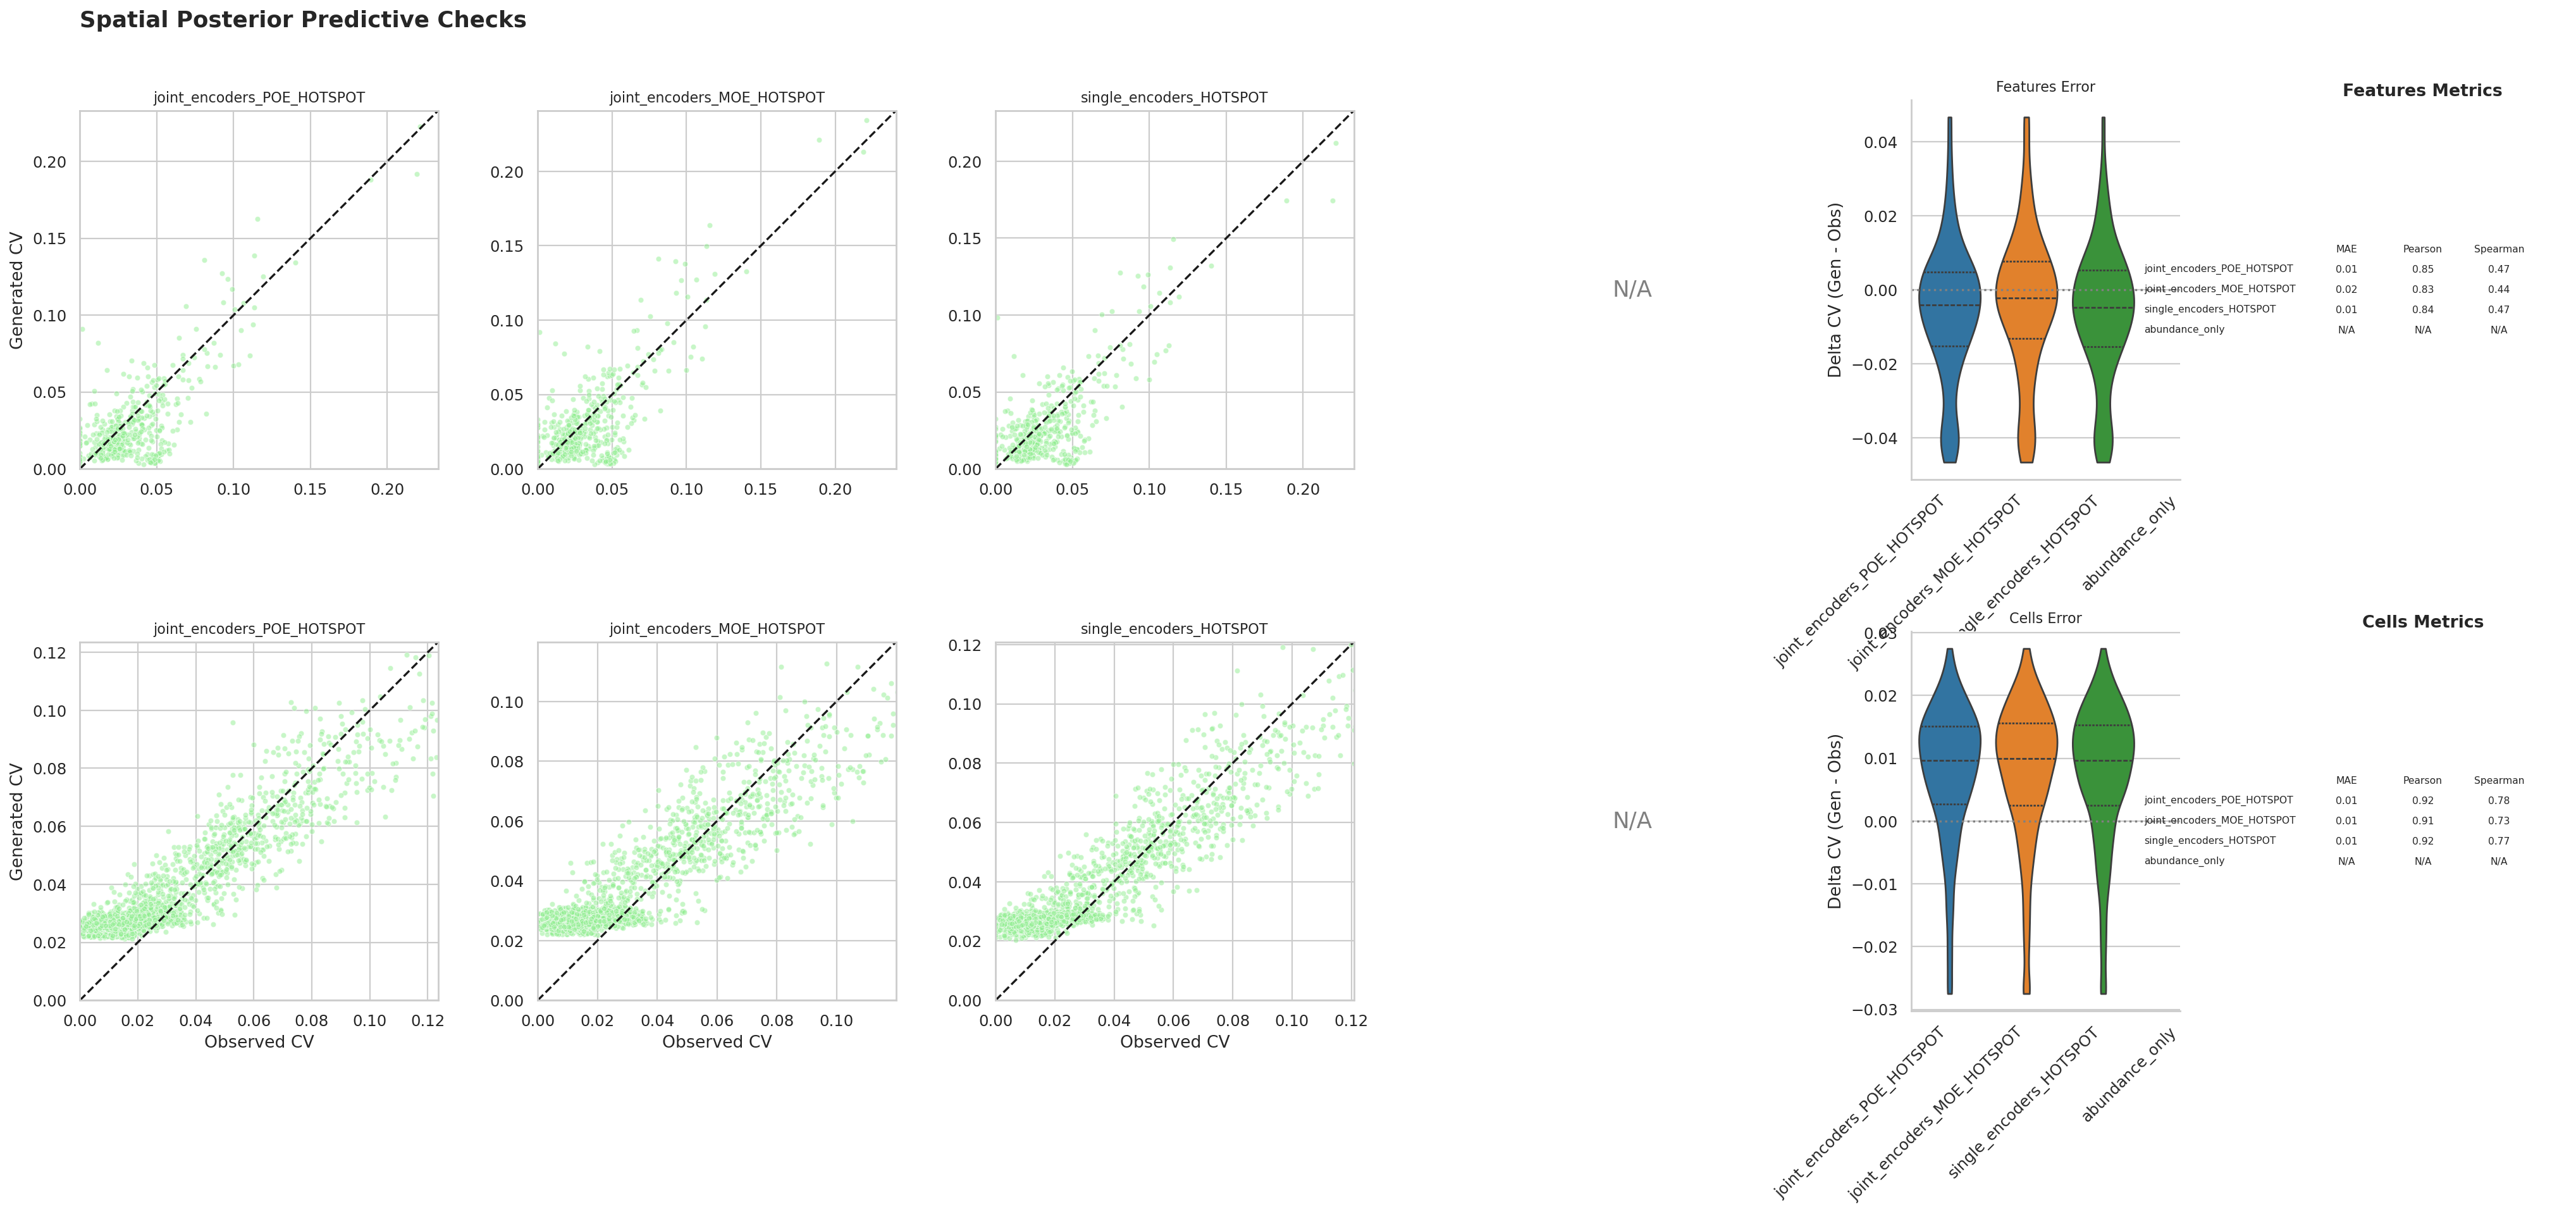

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import gridspec


loaded_models=models_dict.copy()


# --- Configuration & Utility Functions ---

def robust_cv(x, axis, epsilon=0.1):
    """
    Median–IQR coefficient of variation with a robust stabilizer.
    
    The stabilizer (epsilon) prevents division by zero when the median is 0,
    which is common for sparse, zero-centered biological data (Features CV).

    Parameters
    ----------
    x : np.ndarray
        The input expression data (dense, after nan_to_num).
    axis : int
        Axis over which to calculate the CV (0 for Features, 1 for Cells).
    epsilon : float
        The stabilizing constant added to the absolute median (default 0.1).
        
    Returns
    -------
    np.ndarray
        The calculated robust CV values.
    """
    
    # Ensure NaNs are handled (as in your original code)
    x = np.nan_to_num(x, nan=0.0)

    # 1. Calculate Median and Quartiles (IQR)
    # Use np.median and np.percentile since NaNs were already converted to 0.0
    med = np.median(x, axis=axis)
    q25 = np.percentile(x, 25, axis=axis)
    q75 = np.percentile(x, 75, axis=axis)
    iqr = q75 - q25

    # 2. Calculate CV with Robust Stabilizer
    # The absolute value of the median is used, and the larger epsilon (0.1) 
    # ensures stability even when the median is exactly 0.
    
    # Formula: IQR / (|Median| + epsilon)
    cv = iqr / (np.abs(med) + epsilon)
    
    # Clean up any potential extreme values after division (e.g., if IQR was also 0)
    cv = np.nan_to_num(cv, nan=0.0, posinf=0.0, neginf=0.0)

    return cv
def get_dense(data):
    """Converts sparse matrix to dense numpy array if necessary."""
    return data.toarray() if hasattr(data, "toarray") else np.array(data)

def calculate_metrics(obs, gen, model_name, modality_name):
    """Calculates CV metrics (Observed, Generated, Delta) and stats (MAE, R, Rho) for Features and Cells."""
    results = []
    
    for axis, level in [(0, "Features"), (1, "Cells")]:
        c_obs, c_gen = robust_cv(obs, axis), robust_cv(gen, axis)
        delta = c_gen - c_obs
        
        p, _ = stats.pearsonr(c_obs, c_gen)
        s, _ = stats.spearmanr(c_obs, c_gen)
        mae = np.mean(np.abs(delta))

        results.append({
            'Model': model_name,
            'Modality': modality_name,
            'Level': level, 
            'MAE': mae, 'Pearson': p, 'Spearman': s,
            'Observed CV': c_obs, 'Generated CV': c_gen, 'Delta CV': delta
        })
    return results

# --- 1. Load Data and Aggregate Metrics ---

sns.set_style("whitegrid")
all_metrics = []
model_names = list(loaded_models.keys())

# Define common observation data
ab_raw = get_dense(adata.layers[abundance_layer])
sp_raw = get_dense(adata.obsm[spatial_layer])

print("Calculating metrics for all models...")

for model_name, model in loaded_models.items():
    
    # Impute data once per model
    imputed = model.get_normalized_expression(
        adata=adata,
        return_mean_expression=True,
        return_l2_error=True,
        return_px_distrs=False,
        return_numpy=True
    )
    
    # 1. Abundance Modality
    ab_gen = get_dense(imputed['exprs'][abundance_layer])
    all_metrics.extend(calculate_metrics(ab_raw, ab_gen, model_name, 'Abundance'))
    
    # 2. Spatial Modality (Corrected Check)
    if spatial_layer in imputed['exprs'].keys(): 
        try:
            sp_gen = get_dense(imputed['exprs'][spatial_layer])
            all_metrics.extend(calculate_metrics(sp_raw, sp_gen, model_name, 'Spatial'))
        except KeyError:
             print(f"Warning: Model {model_name} failed to extract 'spatial_layer' imputed data.")
             
metrics_df = pd.DataFrame(all_metrics)

# --- 2. Plotting Function (Generates the Composite Figure) ---

def plot_composite_ppc(modality_name, df, scatter_color):
    
    df_modality = df[df['Modality'] == modality_name]
    if df_modality.empty and modality_name == 'Spatial':
        print(f"\nSkipping {modality_name} plot: No models with this modality or data found.")
        return

    N_models = len(model_names)
    # N_cols is now N_models (scatters) + 1 (violin) + 1 (table)
    N_cols = N_models + 2 

    # Figure width increased to accommodate the table column
    fig = plt.figure(figsize=(4.5 * N_cols, 12)) 
    
    # Added extra column width ratio (0.8) for the table
    gs = gridspec.GridSpec(2, N_cols, 
                           height_ratios=[1, 1], width_ratios=[1] * N_models + [0.75, 0.8], left=0.05,
                           wspace=0.3, hspace=0.4, top=0.9) 
    
    table_data = [] 
    
    # Loop over Rows: Features (i=0) and Cells (i=1)
    for i, level in enumerate(["Features", "Cells"]):
        
        df_level = df_modality[df_modality['Level'] == level]
        violin_data = []
        
        # --- Scatter Plots (Columns 0 to N-1) ---
        for j, model_name in enumerate(model_names):
            ax_s = fig.add_subplot(gs[i, j])
            row = df_level[df_level['Model'] == model_name]

            if row.empty:
                # N/A placeholder for missing modality
                ax_s.text(0.5, 0.5, "N/A", fontsize=16, ha='center', va='center', color='gray')
                ax_s.set_xticks([]); ax_s.set_yticks([]); ax_s.set_frame_on(False)
                stats_row = ["N/A"] * 3
            else:
                c_obs = np.concatenate(row['Observed CV'].values)
                c_gen = np.concatenate(row['Generated CV'].values)
                delta = np.concatenate(row['Delta CV'].values)
                
                # Plot Scatter
                ax_s.scatter(c_obs, c_gen, c=scatter_color, s=15, alpha=0.5, ec='white', lw=0.5)
                
                # Robust Limits and Diagonal (99th percentile zoom)
                lim_max = np.percentile(np.concatenate([c_obs, c_gen]), 99) * 1.1
                ax_s.plot([0, lim_max], [0, lim_max], 'k--', lw=1.5)
                ax_s.set_xlim(0, lim_max); ax_s.set_ylim(0, lim_max)
                ax_s.set_aspect('equal')
                
                # Labels - Use full model_name in title
                ax_s.set_title(model_name, fontsize=10) 
                ax_s.set_xlabel("Observed CV" if i == 1 else "")
                ax_s.set_ylabel("Generated CV" if j == 0 else "")

                # Prepare for Violin plot
                df_temp = pd.DataFrame({'Delta CV': delta, 'Model': model_name})
                violin_data.append(df_temp)

                # Store Stats for Table
                stats_row = [f"{row['MAE'].iloc[0]:.2f}", f"{row['Pearson'].iloc[0]:.2f}", f"{row['Spearman'].iloc[0]:.2f}"]
            
            table_data.append(stats_row)

        # --- Violin Plot (Column N) ---
        ax_v = fig.add_subplot(gs[i, N_models])
        
        if violin_data:
            violin_df = pd.concat(violin_data)
            q_abs = np.percentile(np.abs(violin_df['Delta CV'].values), 98)
            violin_df['Delta CV'] = violin_df['Delta CV'].clip(-q_abs, q_abs)

            # Fixed FutureWarning/UserWarning
            sns.violinplot(data=violin_df, x='Model', y='Delta CV', hue='Model', ax=ax_v, 
                           palette='tab10', inner="quartile", cut=0, legend=False)
            
            ax_v.axhline(0, color='gray', ls=':')
            ax_v.set_title(f"{level} Error", fontsize=10)
            ax_v.set_xlabel("")
            ax_v.set_ylabel("Delta CV (Gen - Obs)" if N_models > 0 else "")
            
            ax_v.set_xticks(np.arange(len(model_names))) 
            ax_v.set_xticklabels(model_names, rotation=45, ha='right') 

        sns.despine(ax=ax_v)
        
        # --- Table (Column N+1) ---
        ax_table_col = fig.add_subplot(gs[i, N_models + 1])
        ax_table_col.axis('off')

        # Create a simple table for this row's metrics
        table_metrics_row = []
        for k in range(N_models):
            # If Features row (i=0), take data[k]. If Cells row (i=1), take data[N_models + k].
            metrics = table_data[k] if i == 0 else table_data[N_models + k]
            table_metrics_row.append(metrics)

        table_df = pd.DataFrame(table_metrics_row, index=model_names, 
                                columns=["MAE", "Pearson", "Spearman"])
        
        # Manually create header for the table column
        ax_table_col.text(0.5, 1.0, f'{level} Metrics', ha='center', va='bottom', fontsize=12, fontweight='bold')


        mpl_table = ax_table_col.table(cellText=table_df.values, rowLabels=table_df.index.tolist(), 
                                       colLabels=table_df.columns.tolist(), loc='center', 
                                       cellLoc='center', edges='open')
        
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(7) # Compressed font size
        mpl_table.scale(0.8, 1.2) # Compressed scale
        
    # --- Figure Title ---
    fig.text(0.05, 0.96, f"{modality_name} Posterior Predictive Checks", fontsize=16, fontweight='bold')
    plt.show()

# --- 3. Execute Plots ---

plot_composite_ppc('Abundance', metrics_df, scatter_color='cornflowerblue')
plot_composite_ppc('Spatial', metrics_df, scatter_color='lightgreen')

In [84]:
for model_name, model in models_dict.items():    
    z=model.get_latent_representation(adata,)
    adata.obsm[f'z_{model_name}']=z

INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       
INFO     Using column names from columns of adata.obsm['HOTSPOT_top500_var']                                       


In [86]:
adata.write_h5ad('/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/adata_all_latents.h5ad')

In [85]:
adata

AnnData object with n_obs × n_vars = 2253 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear'
    uns: 'neighbors', 'umap', 'leiden', 'condition_colors', 'run_colors', 'leiden_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'clr', 'log1p', 'spatial_asinh', 'spatial_quantile', 'spatial_raw', 'spatial_tanh4', 'HOTSPOT', 'spatial_arcsinh_top500_var', 'HOTSPOT_top500_var', 'X_umap', 'pca', 'z_abundance_only', 'z_joint_encoders_POE_HOTSPOT', 'z_joint_encoders_MOE_HOTSPOT', 'z_single_encoders_HOTSPOT'
    layers: 'arcsinh', 'clr', 'counts', 'log1p'
    obsp: 'distances', 'connectivities'